In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(directory=DATA_DIR, ext=ext, setting=setting)
dfs.extract_df_info()

Extracting info from filenames..: 100%|████████████████████████████████████████████████████████████████| 28363/28363 [00:03<00:00, 8451.70it/s]


In [4]:
insects = ['v', 'wmv', 'c', 'sw', 't', 'bl', 'm', 'k', 'wrl', 'sp', 'wswl', 'v(cy)']
dfs.df = dfs.df[dfs.df.label.isin(insects)]
dfs.df = dfs.df[~dfs.df['label'].isin(['st','vuil'])]
dfs.df.label = dfs.df.label.apply(lambda x: 'v' if x=='v(cy)' else x)
dfs.df.reset_index(drop=True, inplace=True)
dfs.df.label.value_counts()

v       5407
wmv     5281
c       4575
sw      2542
t       2390
bl      2344
m       1552
k       1087
wrl     1017
sp       800
wswl     688
Name: label, dtype: int64

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.93it/s]


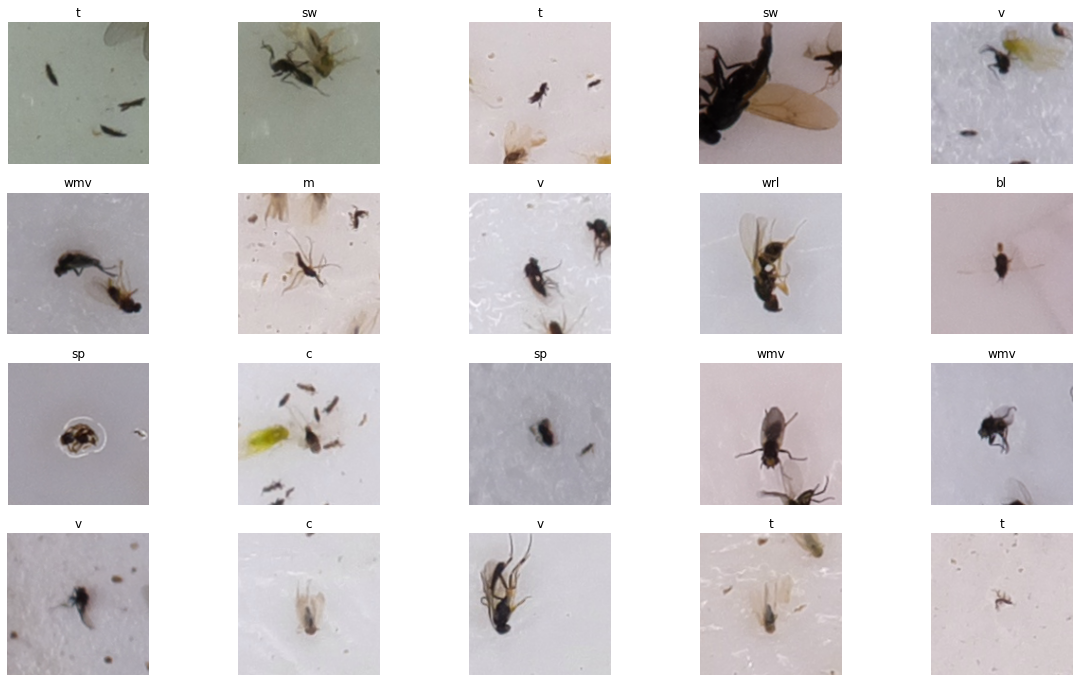

In [5]:
dfs.plot_samples()

# Extra feature collection

In [6]:
batch_size=32
dloader = DataLoader(dfs, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
l_blur_factors = [0]*len(dfs)
l_meansRGB = [0]*len(dfs)
l_stdsRGB = [0]*len(dfs)
l_nb_contours, l_mean_cnt_area, l_mean_cnt_perimeter, l_std_cnt_area, l_std_cnt_perimeter = [0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs)

c=0
for x,l,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(dloader, total=len(dfs)//batch_size, desc='Collecting all data from the dataloader..'):
    for i,f in enumerate(filename):
        l_blur_factors[c] = calc_variance_of_laplacian(f)
        meanRGB, stdRGB = calc_mean_RGB_vals(f)
        l_meansRGB[c] = meanRGB
        l_stdsRGB[c] = stdRGB
        nb_contours, mean_cnt_area, mean_cnt_perimeter, std_cnt_area, std_cnt_perimeter = calc_contour_features(f)
        l_nb_contours[c] = nb_contours
        l_mean_cnt_area[c] = mean_cnt_area
        l_mean_cnt_perimeter[c] = mean_cnt_perimeter
        l_std_cnt_area[c] = std_cnt_area
        l_std_cnt_perimeter[c] = std_cnt_perimeter
        c+=1

  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
df_rgb = pd.DataFrame(l_meansRGB, columns=['R','G','B'])
df_feats = pd.DataFrame({'blur': l_blur_factors, 
                        'nb_contours': l_nb_contours,
                        'mean_cnt_area': l_mean_cnt_area,
                        'mean_cnt_perimeter': l_mean_cnt_perimeter,
                        'std_cnt_area': l_std_cnt_area,
                        'std_cnt_perimeter': l_std_cnt_perimeter})
df_feats = pd.concat([df_feats, df_rgb], axis=1)
feature_columns = df_feats.columns


df = pd.concat([dfs.df, df_feats], axis=1)
df.sort_values(by='label', inplace=True)

df = df[~df.label.isin(['gv','sl'])]

insect_classes = df.label.unique().tolist()

df.head()

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,nb_contours,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B
0,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_UNDISTORTED_herent_w28_1-90_4056x3040_202...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,2020,herent,w28,1-90,11869,42.842744,4,116.875000,40.238329,132.378423,37.283882,205.431857,204.239418,210.109485
1558,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_B_w23_4056x3040.png_bl_351,UNDISTORTED_arc_B_w23_4056x3040.png,2021,arc,w23,b,351,37.085413,52,58.509615,20.981084,246.093331,54.785250,151.480978,148.637911,155.535556
1559,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_B_w23_4056x3040.png_bl_352,UNDISTORTED_arc_B_w23_4056x3040.png,2021,arc,w23,b,352,33.265278,39,49.974359,24.898298,184.089685,64.250253,151.844667,148.271244,155.080311
1560,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_B_w23_4056x3040.png_bl_354,UNDISTORTED_arc_B_w23_4056x3040.png,2021,arc,w23,b,354,27.135728,14,54.357143,34.127777,164.991605,90.345554,154.855467,151.756667,158.230178
1561,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_B_w23_4056x3040.png_bl_356,UNDISTORTED_arc_B_w23_4056x3040.png,2021,arc,w23,b,356,59.290321,19,104.552632,42.258354,334.068418,95.992605,166.921467,158.195867,160.418711


# Outlier detection

### Performed per insect class

In [9]:
l_outlier_features = ['blur', 'nb_contours', 'R','G','B']

def class_outliers(df, features, insect='bl'):
    df = df[df.label==insect]
    outlier, outlier_score = detect_outliers(df[features].fillna(0).values, algorithm='KNN')    
    return outlier, outlier_score

df['knn_outlier'], df['knn_outlier_score'] = 0,0
outliers, scores = [],[]
for ins in tqdm(insect_classes, total=len(insect_classes)):
    out, scr = class_outliers(df, l_outlier_features, insect=ins)
    assert len(out) == df[df.label==ins].shape[0]
    outliers.extend(out)
    scores.extend(scr)
    
df['knn_outlier'], df['knn_outlier_score'] = outliers, scores

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.52it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 61.19it/s]


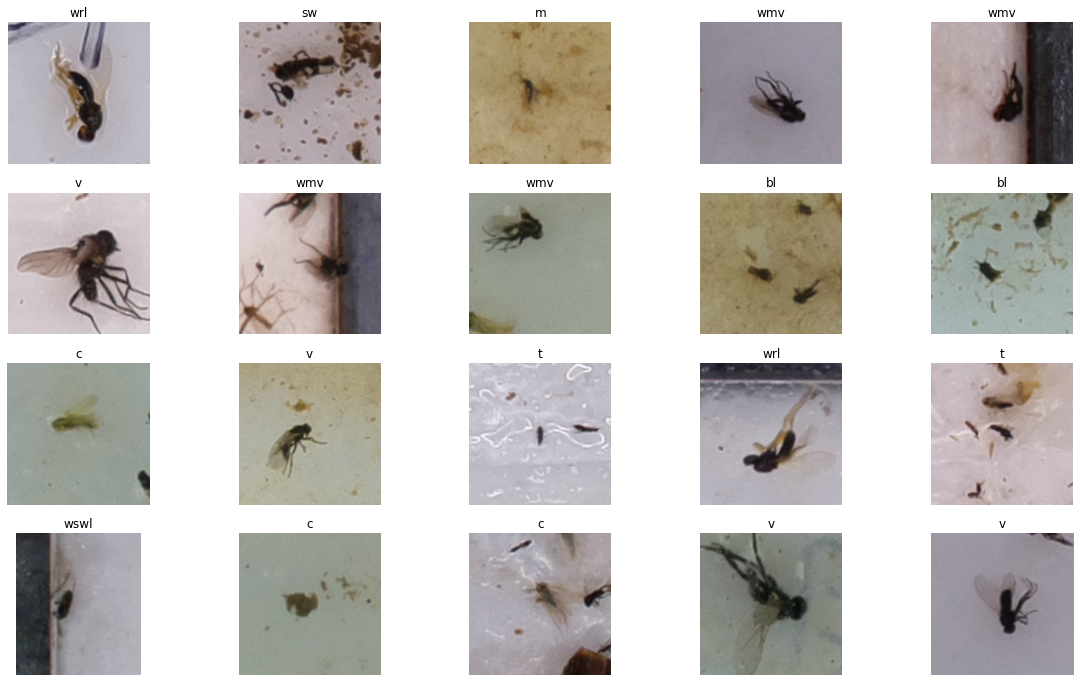

In [10]:
dfs.plot_samples(df[df.knn_outlier==1].sample(20))

In [11]:
df

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,nb_contours,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B,knn_outlier,knn_outlier_score
0,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_UNDISTORTED_herent_w28_1-90_4056x3040_202...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,2020,herent,w28,1-90,11869,42.842744,4,116.875000,40.238329,132.378423,37.283882,205.431857,204.239418,210.109485,0,0.132859
1558,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_B_w23_4056x3040.png_bl_351,UNDISTORTED_arc_B_w23_4056x3040.png,2021,arc,w23,b,351,37.085413,52,58.509615,20.981084,246.093331,54.785250,151.480978,148.637911,155.535556,0,0.350908
1559,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_B_w23_4056x3040.png_bl_352,UNDISTORTED_arc_B_w23_4056x3040.png,2021,arc,w23,b,352,33.265278,39,49.974359,24.898298,184.089685,64.250253,151.844667,148.271244,155.080311,0,0.246079
1560,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_B_w23_4056x3040.png_bl_354,UNDISTORTED_arc_B_w23_4056x3040.png,2021,arc,w23,b,354,27.135728,14,54.357143,34.127777,164.991605,90.345554,154.855467,151.756667,158.230178,0,0.176218
1561,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_B_w23_4056x3040.png_bl_356,UNDISTORTED_arc_B_w23_4056x3040.png,2021,arc,w23,b,356,59.290321,19,104.552632,42.258354,334.068418,95.992605,166.921467,158.195867,160.418711,0,0.322172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27225,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w38_4056x3040.png_ws...,UNDISTORTED_landen_B_w38_4056x3040.png,2021,landen,w38,b,1132,30.025999,8,116.375000,31.977922,230.688474,47.833538,178.552185,162.966711,162.906799,0,0.222939
27226,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w38_4056x3040.png_ws...,UNDISTORTED_landen_B_w38_4056x3040.png,2021,landen,w38,b,1134,38.498976,9,190.555556,57.303334,529.442130,144.657657,177.114178,161.101422,161.628089,0,0.263143
27227,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w38_4056x3040.png_ws...,UNDISTORTED_landen_B_w38_4056x3040.png,2021,landen,w38,b,1142,27.707360,18,76.777778,38.200681,194.744721,71.338890,169.972133,151.614000,152.239511,0,0.284175
27219,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_b_w37_4056x3040.png_ws...,UNDISTORTED_landen_b_w37_4056x3040.png,2021,landen,w37,b,2602,18.045333,17,67.794118,16.065873,262.933343,44.304945,155.248933,151.187511,157.904356,0,0.218068


In [12]:
print(f"Total of {df[df.knn_outlier==1].shape[0]} outliers found. (# of all datapoints: {df.shape[0]})")
df[df.knn_outlier==1].label.value_counts()

Total of 2771 outliers found. (# of all datapoints: 27683)


v       541
wmv     528
c       458
sw      255
t       238
bl      235
m       156
k       109
wrl     102
sp       80
wswl     69
Name: label, dtype: int64

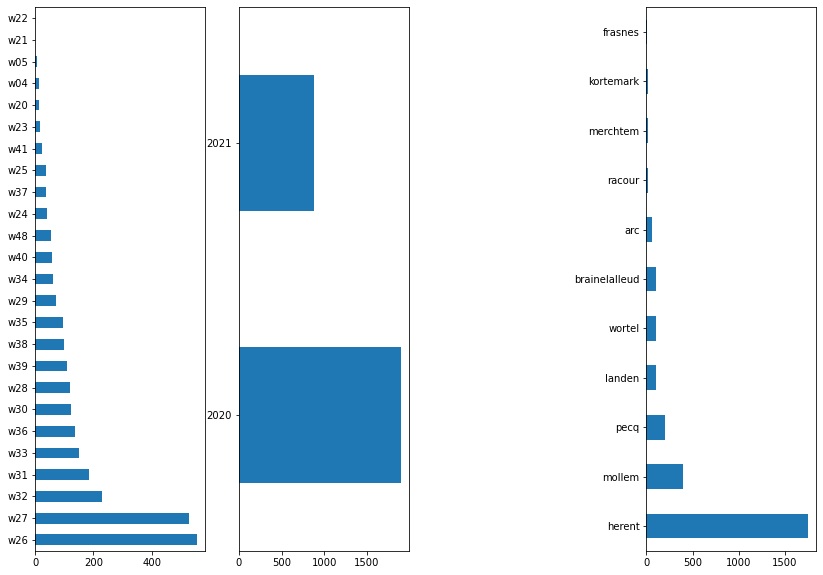

In [13]:
plt.figure(figsize=(24,12))
plt.subplot(1,4,1);
df[df.knn_outlier==1].date.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,2);
df[df.knn_outlier==1].year.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,4);
df[df.knn_outlier==1].location.value_counts().plot(kind='barh', figsize=(14,10));

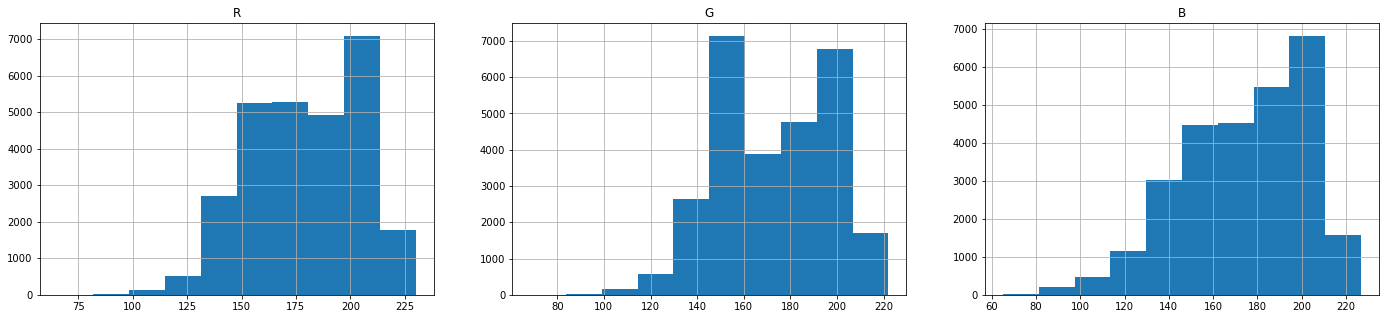

In [14]:
plt.figure(figsize=(24,5))
plt.subplot(1,3,1);
df.R.hist();plt.title('R')
plt.subplot(1,3,2);
df.G.hist();plt.title('G')
plt.subplot(1,3,3);
df.B.hist();plt.title('B');

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 60.81it/s]


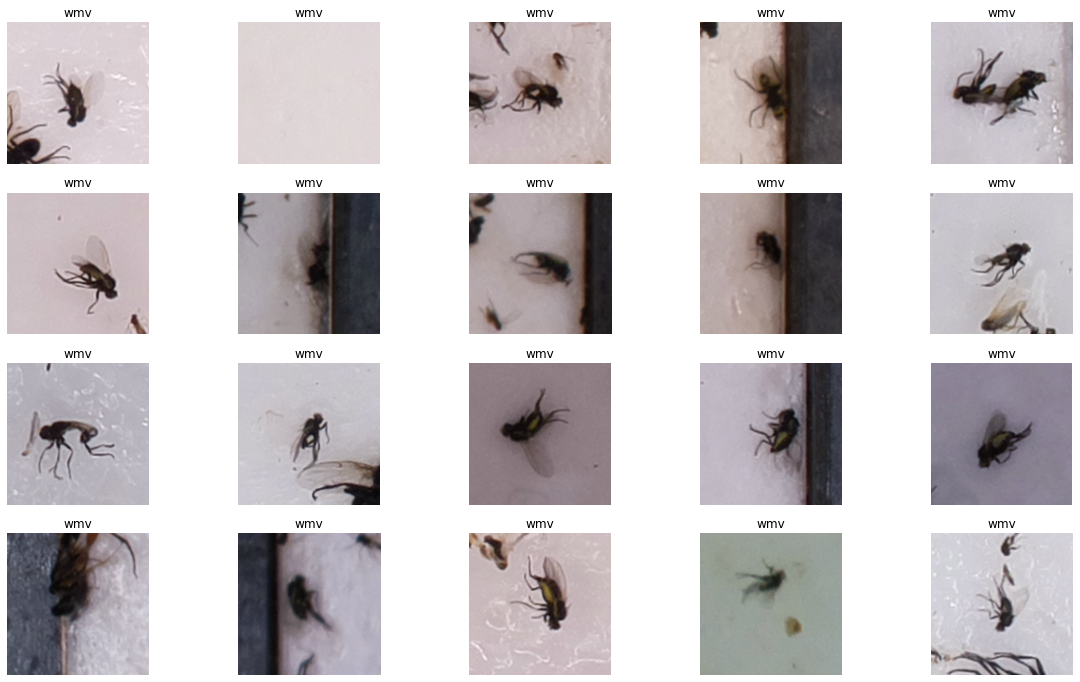

In [15]:
selection = 'label==\'wmv\' & knn_outlier==1 & nb_contours<15'
# selection = 'knn_outlier==1 & label==\'wmv\''
dfs.plot_samples(df.query(selection).sample(20))

In [16]:
df.query(selection).date.value_counts()

w38    21
w36    10
w39     9
w33     7
w32     7
w37     6
w40     5
w34     4
w30     3
w35     2
w27     2
w28     2
w29     1
w31     1
Name: date, dtype: int64

# CALCULAE IF INSECT IS CLOSER TO THE EDGE OF FOTO

In [17]:
# df[df.knn_outlier==0]

In [18]:
df.to_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')